***Mount Google Drive to the notebook***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***1. make sure kaggle is installed.***

In [ ]:
! pip install kaggle

***2. Make a directory named “.kaggle”***

In [ ]:
! mkdir ~/.kaggle


***3. Copy the “kaggle.json” (Kaggle Api Credentials) into this new directory***

In [ ]:
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/


***4. Allocate the required permission for this file.***

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json


***Download the dataset from Kaggle.***

In [ ]:
! kaggle datasets download gabrielluizone/us-domestic-flights-delay-prediction-2013-2018

Dataset URL: https://www.kaggle.com/datasets/gabrielluizone/us-domestic-flights-delay-prediction-2013-2018
License(s): CC0-1.0
100% 1.50G/1.50G [00:18<00:00, 44.2MB/s]
100% 1.50G/1.50G [00:18<00:00, 86.5MB/s]


***Create a directory and unzip the downloaded dataset***

In [ ]:
!mkdir flight-delay-prediction

In [ ]:
!unzip /content/us-domestic-flights-delay-prediction-2013-2018.zip -d flight-delay-prediction

Archive:  /content/us-domestic-flights-delay-prediction-2013-2018.zip
  inflating: flight-delay-prediction/csv_flight/report_2014_1.csv  
  inflating: flight-delay-prediction/csv_flight/report_2014_10.csv  
  inflating: flight-delay-prediction/csv_flight/report_2014_11.csv  
  inflating: flight-delay-prediction/csv_flight/report_2014_12.csv  
  inflating: flight-delay-prediction/csv_flight/report_2014_2.csv  
  inflating: flight-delay-prediction/csv_flight/report_2014_3.csv  
  inflating: flight-delay-prediction/csv_flight/report_2014_4.csv  
  inflating: flight-delay-prediction/csv_flight/report_2014_5.csv  
  inflating: flight-delay-prediction/csv_flight/report_2014_6.csv  
  inflating: flight-delay-prediction/csv_flight/report_2014_7.csv  
  inflating: flight-delay-prediction/csv_flight/report_2014_8.csv  
  inflating: flight-delay-prediction/csv_flight/report_2014_9.csv  
  inflating: flight-delay-prediction/csv_flight/report_2015_1.csv  
  inflating: flight-delay-prediction/csv_fl

***Import the needed libraries***

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras import Sequential, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

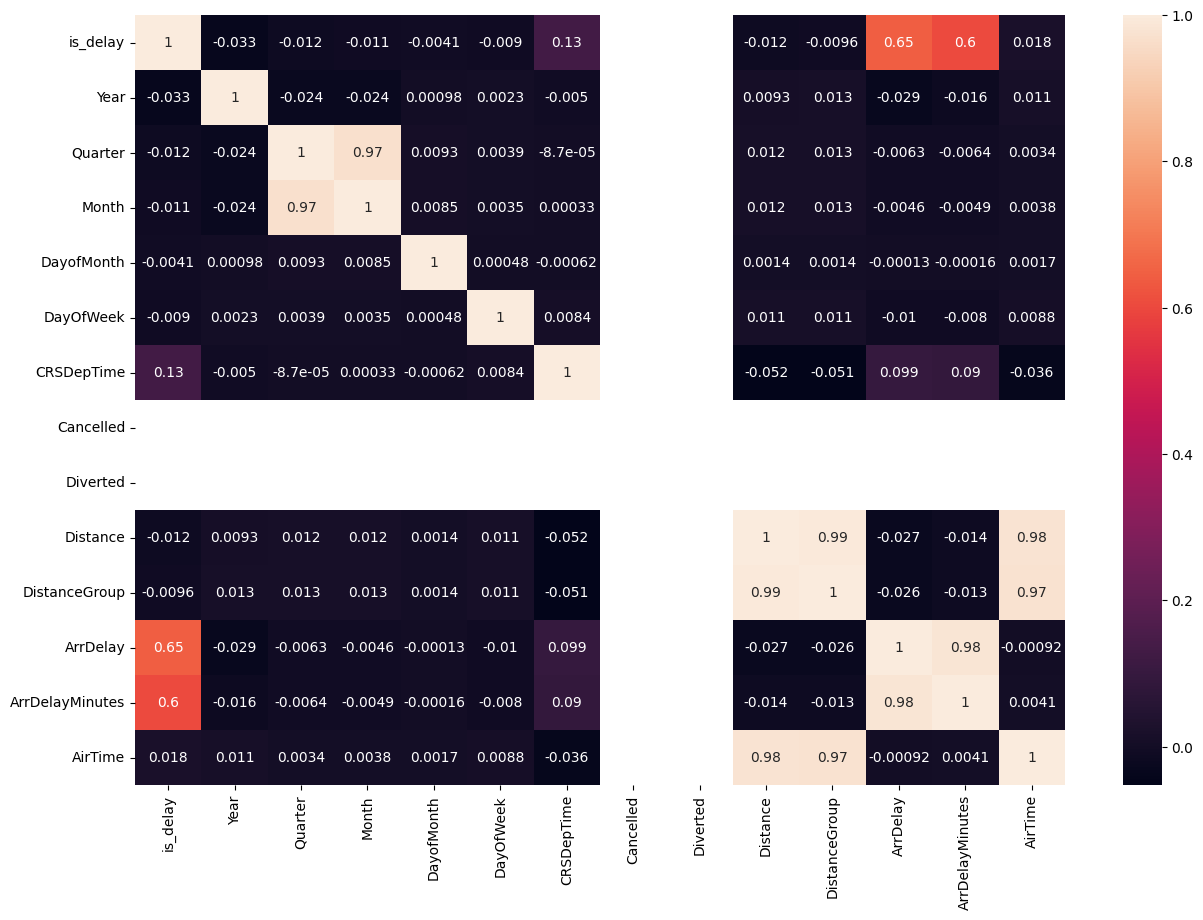

In [ ]:

data = pd.read_csv('/content/flight-delay-prediction/flight_delay_predict.csv')


avg_delay_by_origin = data.groupby('Origin')['ArrDelay'].mean().reset_index()

bar_plot = px.bar(avg_delay_by_origin, x='Origin', y='ArrDelay', title='Average Arrival Delay by Origin Airport')
bar_plot.update_layout(xaxis_title='Origin Airport', yaxis_title='Average Arrival Delay')

bar_plot.show()

avg_delay_by_dest = data.groupby('Dest')['ArrDelay'].mean().reset_index()

bar_plot_dest = px.bar(avg_delay_by_dest, x='Dest', y='ArrDelay', title='Average Arrival Delay by Destination Airport')
bar_plot_dest.update_layout(xaxis_title='Destination Airport', yaxis_title='Average Arrival Delay')

bar_plot_dest.show()

numeric_data = data.select_dtypes(include=['number'])

corr_matrix = numeric_data.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot = True)

data['FlightDate'] = pd.to_datetime(data['FlightDate'])

avg_delay_month = data.groupby(data['FlightDate'].dt.month)['is_delay'].mean().reset_index()
fig = px.bar(avg_delay_month, x='FlightDate', y='is_delay', labels={'FlightDate': 'Month',
'is_delay': 'Average Delay'}, title='Average Delay by Month')
fig.update_traces(marker_color='skyblue')
fig.show()




***Show data***

In [ ]:
data.head()

,is_delay,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Origin,OriginState,Dest,DestState,CRSDepTime,Cancelled,Diverted,Distance,DistanceGroup,ArrDelay,ArrDelayMinutes,AirTime
0,1.0,2014,1,1,1,3,2014-01-01,UA,LAX,CA,ORD,IL,900,0.0,0.0,1744.0,7,43.0,43.0,218.0
1,0.0,2014,1,1,1,3,2014-01-01,AA,IAH,TX,DFW,TX,1750,0.0,0.0,224.0,1,2.0,2.0,50.0
2,1.0,2014,1,1,1,3,2014-01-01,AA,LAX,CA,ORD,IL,1240,0.0,0.0,1744.0,7,26.0,26.0,220.0
3,1.0,2014,1,1,1,3,2014-01-01,AA,DFW,TX,LAX,CA,1905,0.0,0.0,1235.0,5,159.0,159.0,169.0
4,0.0,2014,1,1,1,3,2014-01-01,AA,DFW,TX,CLT,NC,1115,0.0,0.0,936.0,4,-13.0,0.0,108.0


***Preprocessing the data***

In [ ]:
from sklearn.preprocessing import MinMaxScaler


# 2. Preprocessing the data
# Drop rows with missing values (if any)
data = data.dropna()

encoder = LabelEncoder()
data['Reporting_Airline'] = encoder.fit_transform(data['Reporting_Airline'])
data['Origin'] = encoder.fit_transform(data['Origin'])
data['OriginState'] = encoder.fit_transform(data['OriginState'])
data['Dest'] = encoder.fit_transform(data['Dest'])
data['DestState'] = encoder.fit_transform(data['DestState'])




# Additional feature engineering
data['Hour'] = data['CRSDepTime'] // 100  # Extract hour from departure time
data['Morning_Flight'] = np.where((data['Hour'] >= 6) & (data['Hour'] < 12), 1, 0)  # Morning flight indicator
data['Evening_Flight'] = np.where((data['Hour'] >= 18) & (data['Hour'] < 24), 1, 0)  # Evening flight indicator
data['Weekend'] = np.where(data['DayOfWeek'].isin([6, 7]), 1, 0)  # Weekend indicator




In [ ]:
# Split features and target variable for classification
X_cls = data.drop(['is_delay', 'ArrDelay', 'ArrDelayMinutes', 'FlightDate'], axis=1)
y_delay_cls = data['is_delay']

In [ ]:
# Split data into train, validation, and test sets
X_train_cls, X_temp_cls, y_train_cls, y_temp_cls = train_test_split(
    X_cls, y_delay_cls, test_size=0.3, random_state=42  # Reserve 30% for validation + test
)
X_val_cls, X_test_cls, y_val_cls, y_test_cls = train_test_split(
    X_temp_cls, y_temp_cls, test_size=0.5, random_state=42  # Split remaining 30% into validation (15%) and test (15%)
)

In [ ]:
# Define preprocessing pipeline for classification
numeric_features_cls = X_cls.select_dtypes(include=['int64', 'float64']).columns.tolist()
scaler_cls = StandardScaler()
X_train_cls[numeric_features_cls] = scaler_cls.fit_transform(X_train_cls[numeric_features_cls])
X_val_cls[numeric_features_cls] = scaler_cls.transform(X_val_cls[numeric_features_cls])
X_test_cls[numeric_features_cls] = scaler_cls.transform(X_test_cls[numeric_features_cls])

In [ ]:
# Define the classification model
model_cls = Sequential([
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])


# Compile the model
model_cls.compile(
    optimizer='adam',                           # Adam optimizer
    loss='binary_crossentropy',                 # Binary cross-entropy loss for binary classification
    metrics=['accuracy']                        # Accuracy as the evaluation metric
)


# Fit the model to the training data
history = model_cls.fit(
    X_train_cls,                                # Training input data
    y_train_cls,                                # Training labels
    validation_data=(X_val_cls, y_val_cls),     # Validation data
    epochs=20,                                  # Number of training epochs
    batch_size=32,                              # Batch size
    verbose=1                                   # Verbosity mode (1 for progress bar)
)

Epoch 1/20
35779/35779 ━━━━━━━━━━━━━━━━━━━━ 127s 3ms/step - accuracy: 0.7936 - loss: 0.4927 - val_accuracy: 0.8000 - val_loss: 0.4734
Epoch 2/20
35779/35779 ━━━━━━━━━━━━━━━━━━━━ 135s 4ms/step - accuracy: 0.7979 - loss: 0.4784 - val_accuracy: 0.7993 - val_loss: 0.4719
Epoch 3/20
35779/35779 ━━━━━━━━━━━━━━━━━━━━ 144s 4ms/step - accuracy: 0.7995 - loss: 0.4749 - val_accuracy: 0.7974 - val_loss: 0.4722
Epoch 4/20
35779/35779 ━━━━━━━━━━━━━━━━━━━━ 123s 3ms/step - accuracy: 0.7996 - loss: 0.4731 - val_accuracy: 0.8000 - val_loss: 0.4679
Epoch 5/20
35779/35779 ━━━━━━━━━━━━━━━━━━━━ 126s 4ms/step - accuracy: 0.7997 - loss: 0.4720 - val_accuracy: 0.7994 - val_loss: 0.4670
Epoch 6/20
35779/35779 ━━━━━━━━━━━━━━━━━━━━ 145s 4ms/step - accuracy: 0.8007 - loss: 0.4705 - val_accuracy: 0.8008 - val_loss: 0.4648
Epoch 7/20
35779/35779 ━━━━━━━━━━━━━━━━━━━━ 156s 4ms/step - accuracy: 0.8003 - loss: 0.4716 - val_accuracy: 0.7997 - val_loss: 0.4662
Epoch 8/20
35779/35779 ━━━━━━━━━━━━━━━━━━━━ 188s 4ms/step - ac

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_cls.evaluate(X_test_cls, y_test_cls, verbose=1)

# Print evaluation metrics
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

7667/7667 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.8013 - loss: 0.4632
Test Loss: 0.4631
Test Accuracy: 0.8008


In [20]:
from sklearn.metrics import classification_report, confusion_matrix

# Generate predictions
y_pred_cls = (model_cls.predict(X_test_cls) > 0.5).astype("int32")  # Convert sigmoid output to binary (0/1)

# Classification report
print("Classification Report:")
print(classification_report(y_test_cls, y_pred_cls, target_names=['Class 0', 'Class 1']))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test_cls, y_pred_cls))

7667/7667 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.80      1.00      0.89    193647
     Class 1       0.80      0.07      0.13     51692

    accuracy                           0.80    245339
   macro avg       0.80      0.53      0.51    245339
weighted avg       0.80      0.80      0.73    245339

Confusion Matrix:
[[192690    957]
 [ 47923   3769]]
